In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from utils.skeleton_utils import (
    get_branching_points,
    get_crossing_points,
    get_endpoints,
)

%matplotlib ipympl

In [2]:
def load_skeltonised_mask_from_png(file_path):
    """
    Load a binary skeletonised mask from a png file.

    Args:
        file_path (str): Path to the png file.

    Returns:
        np.ndarray: Binary skeletonised mask.
    """

    # Load image
    img = Image.open(file_path)
    img = img.convert("L")
    img = np.array(img)

    # Convert to binary
    img = (img > 0).astype(np.uint8)

    return img


# Load binary skeletonised instances from png file
skeletonised_mask = load_skeltonised_mask_from_png(
    "../sample_data/skeletonised_masks/exp1_block1_pot31_4_skeletonised_mask.png"
)

In [3]:
# Load original image so that we can overlay the skeleton on top of it
original_image = Image.open(
    "../sample_data/niab/EXP01/Top_Images/Top_Images_Clean_Rename/EXP01_Block01/EXP01_Block01_Rename05_20201202/Exp01_Block01_Image05_Pot031.jpg"
)

# Resize the original image to match the skeletonised mask
original_image = original_image.resize(
    (skeletonised_mask.shape[1], skeletonised_mask.shape[0])
)

Number of endpoints: 62
Number of branching points: 26
Number of crossing points: 16


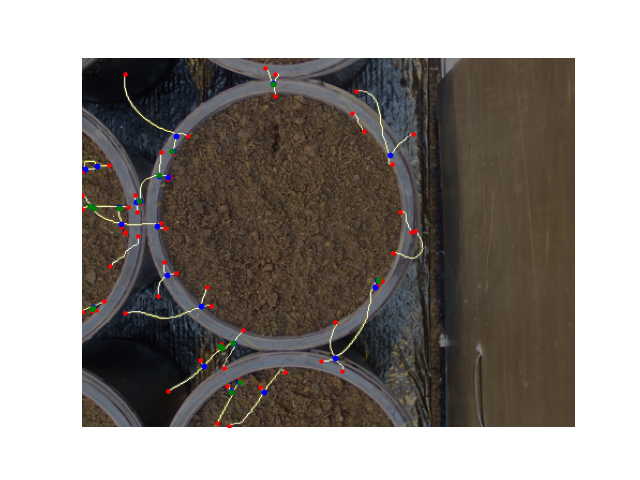

In [4]:
# Get endpoints, branching points and crossing points
endpoints = get_endpoints(skeletonised_mask)
branching_points = get_branching_points(skeletonised_mask)
crossing_points = get_crossing_points(skeletonised_mask)

print(f"Number of endpoints: {endpoints.shape[0]}")
print(f"Number of branching points: {branching_points.shape[0]}")
print(f"Number of crossing points: {crossing_points.shape[0]}")

# Display the skeletonised mask with the points
plt.figure()
plt.imshow(skeletonised_mask, cmap="gray")
plt.imshow(original_image, alpha=0.5)
plt.scatter(endpoints[:, 1], endpoints[:, 0], c="r", s=5)
plt.scatter(branching_points[:, 1], branching_points[:, 0], c="b", s=10)
plt.scatter(crossing_points[:, 1], crossing_points[:, 0], c="g", s=10)
plt.axis("off")
plt.show()

35


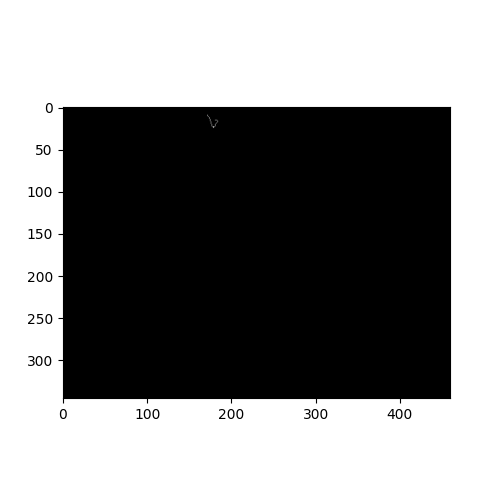

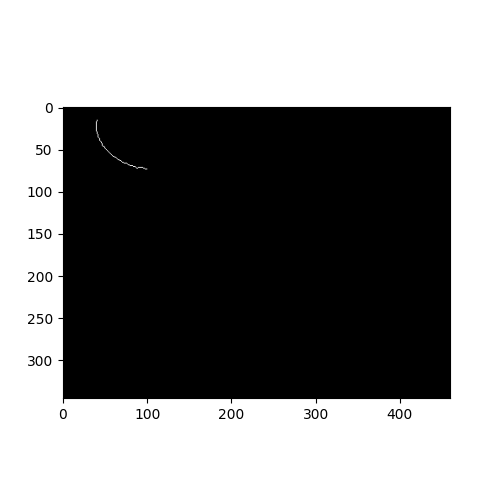

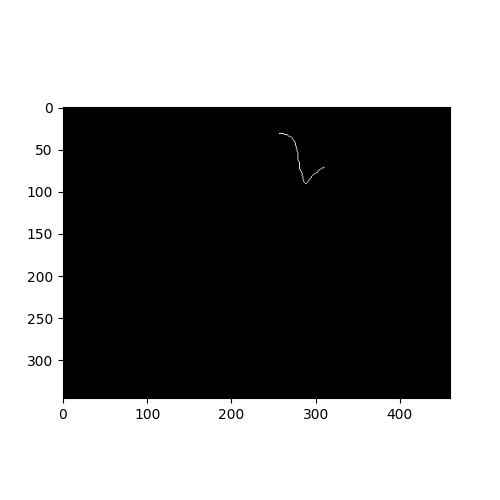

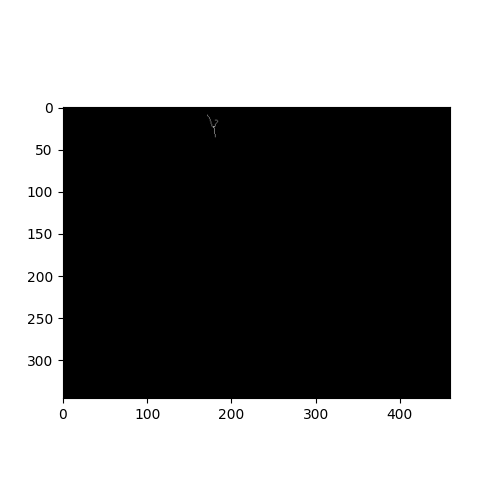

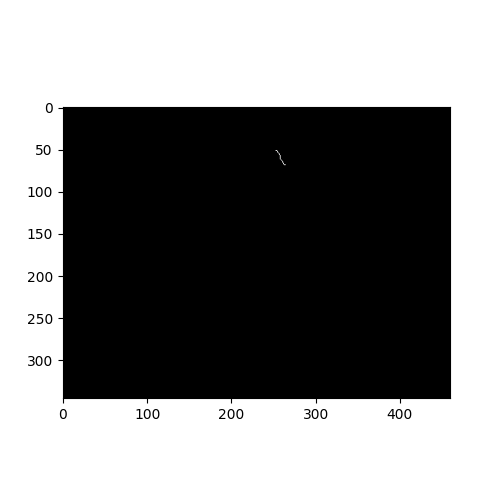

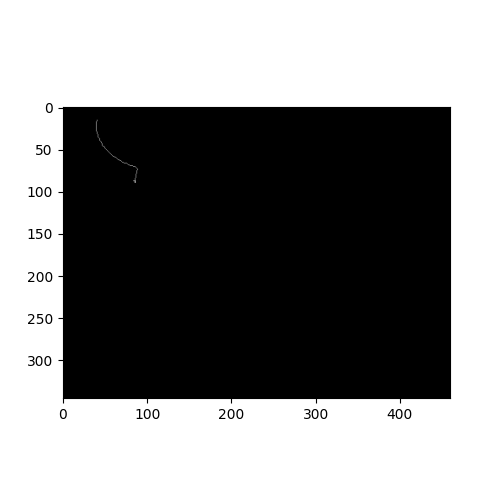

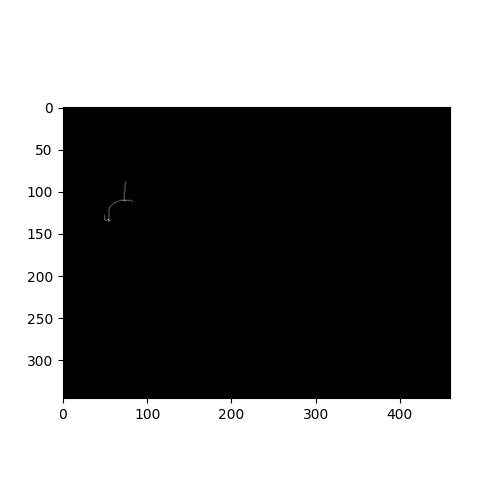

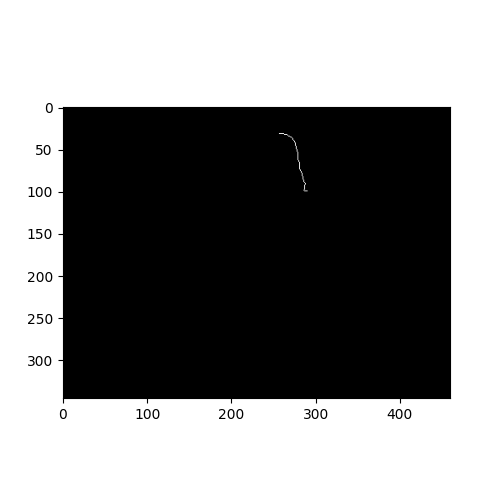

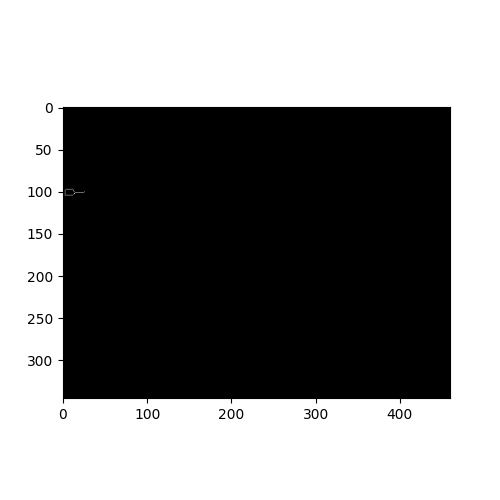

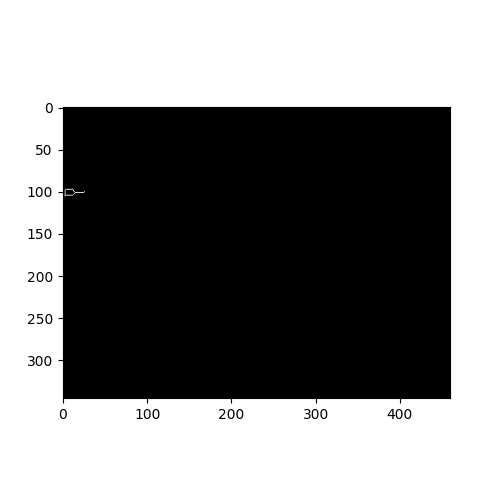

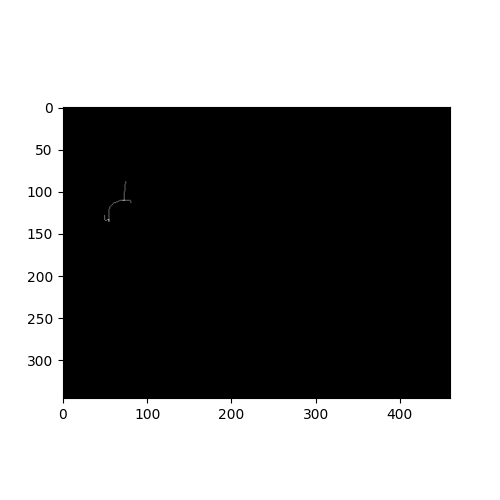

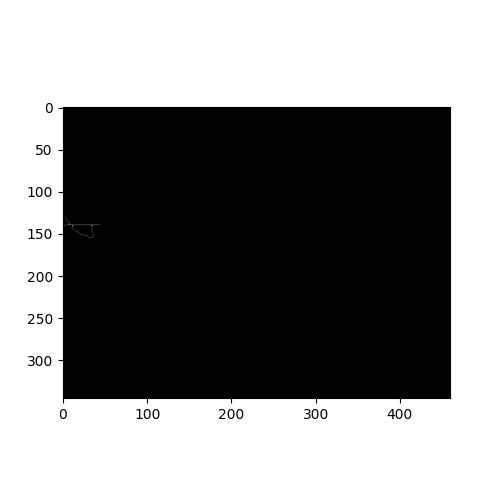

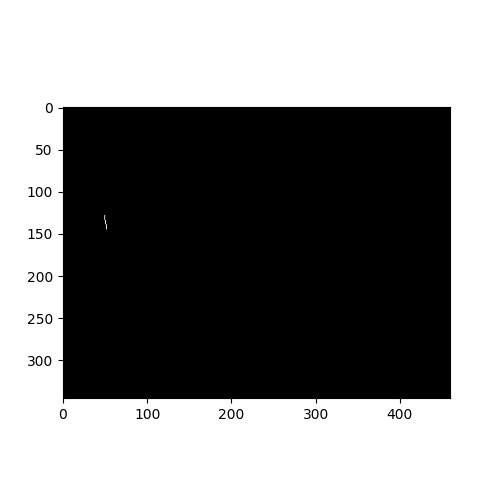

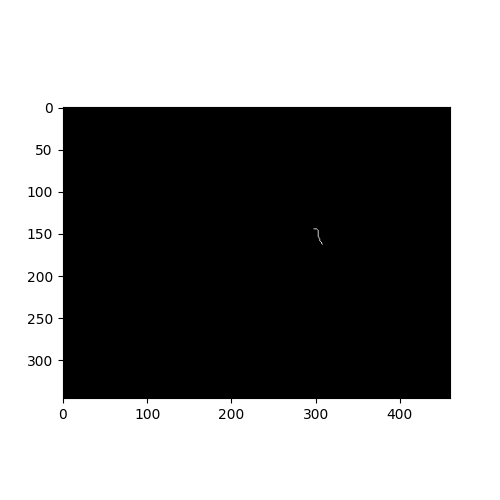

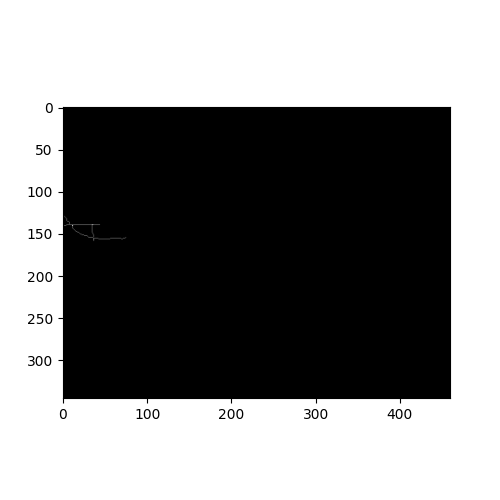

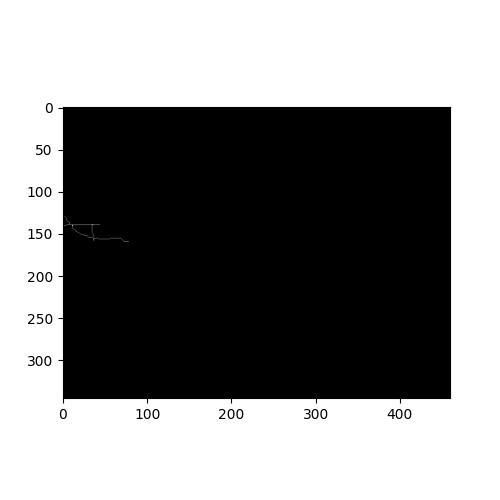

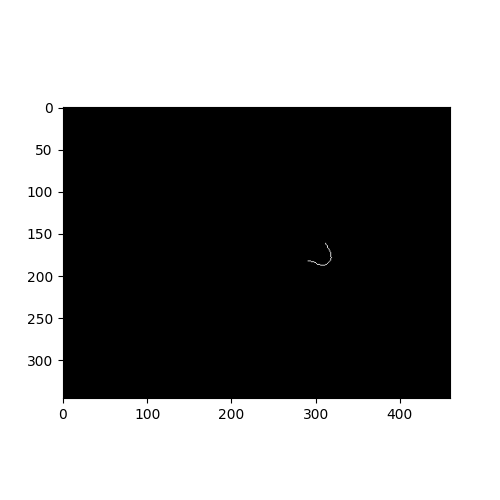

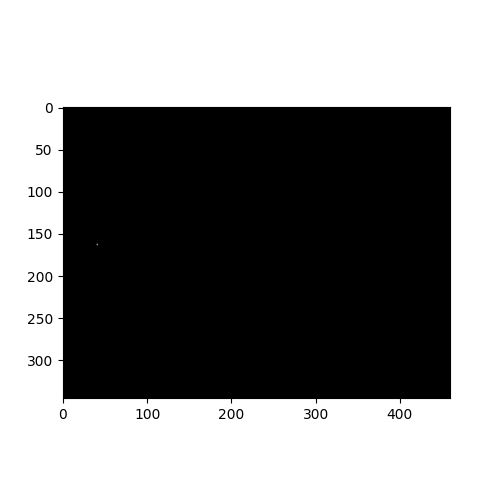

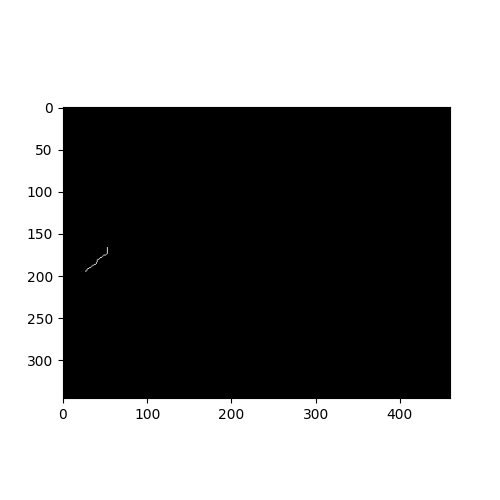

/tmp/ipykernel_56197/2158708123.py:163: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))


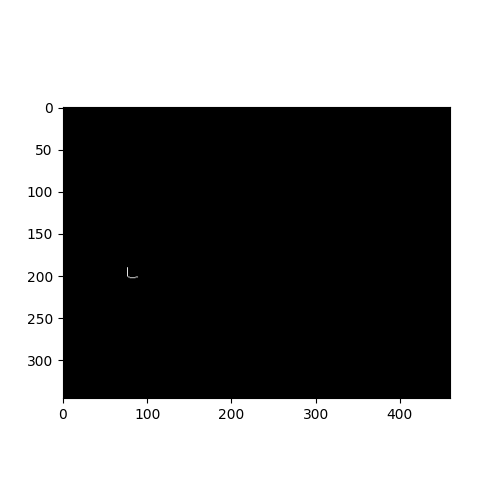

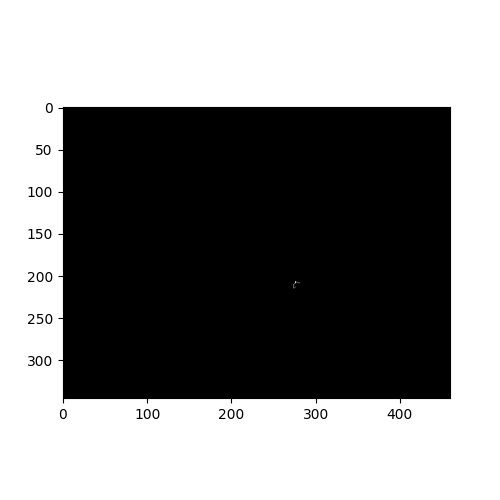

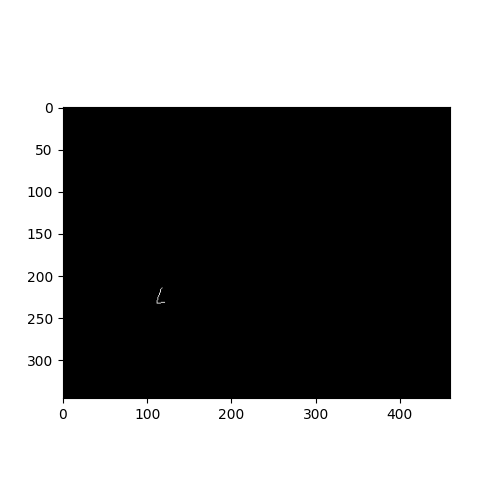

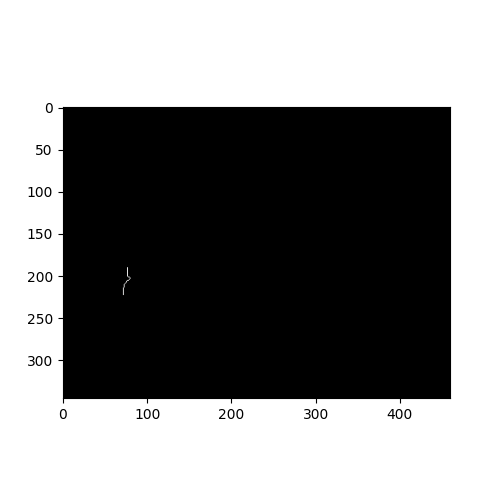

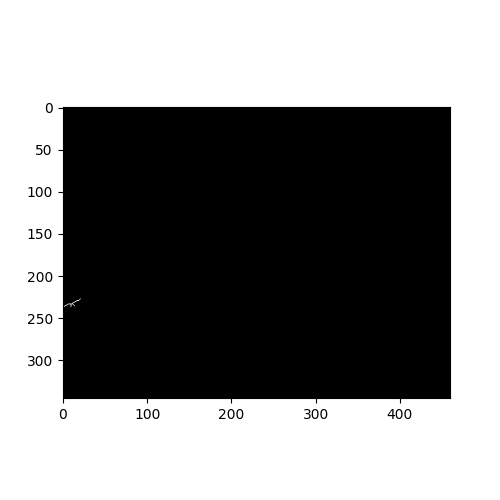

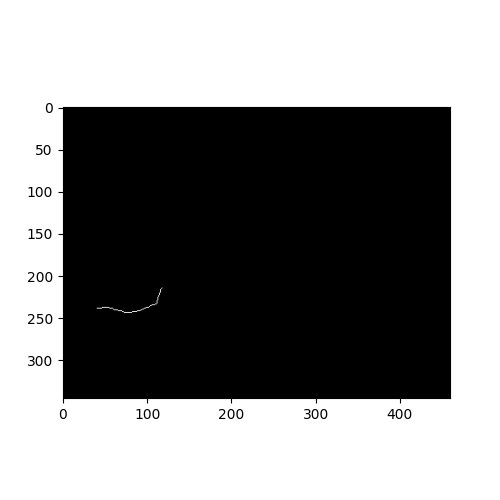

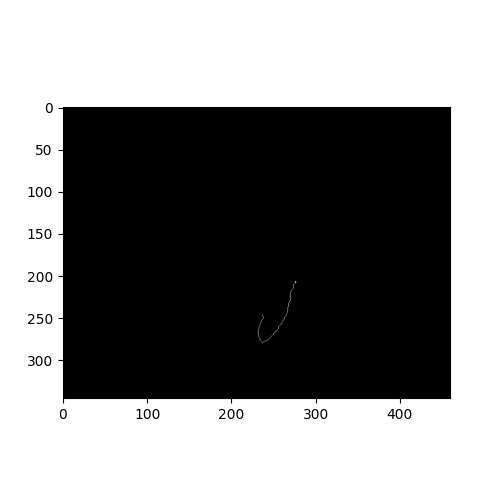

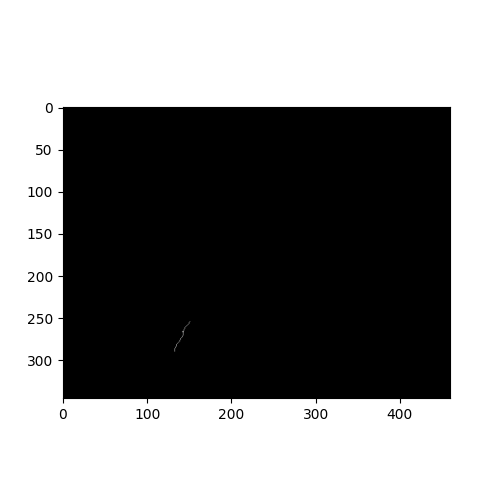

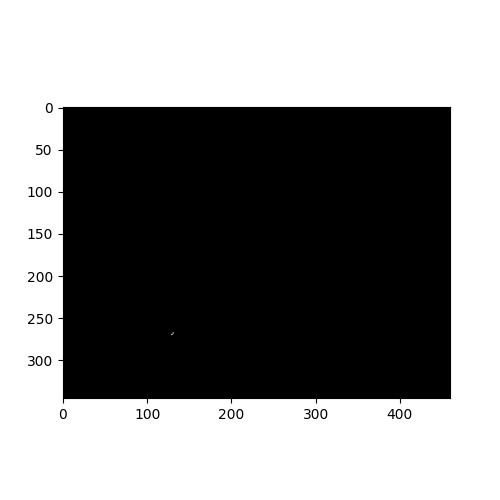

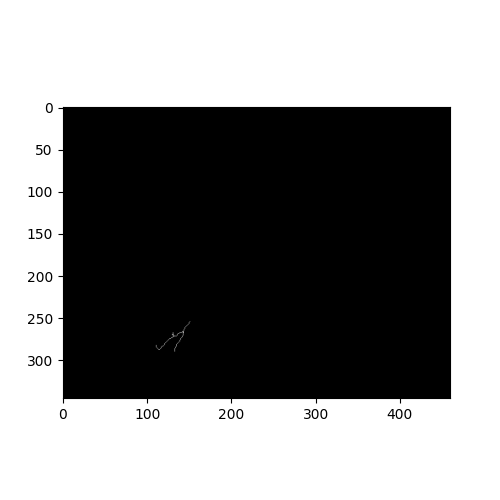

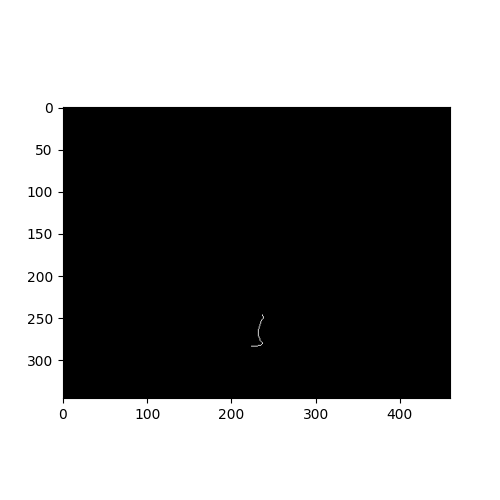

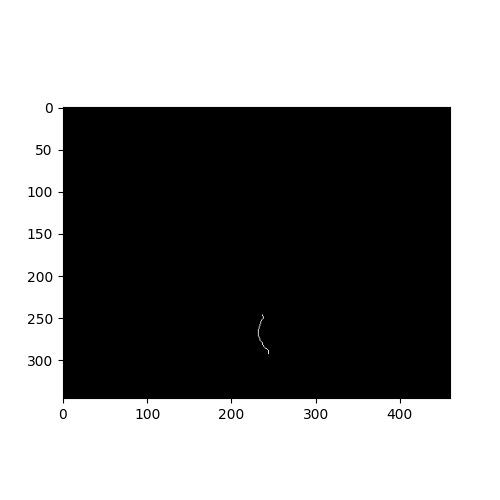

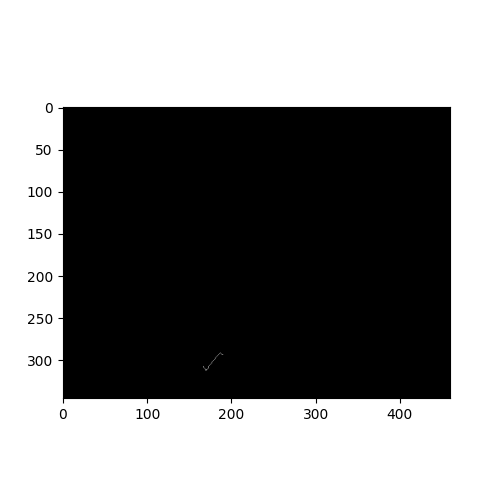

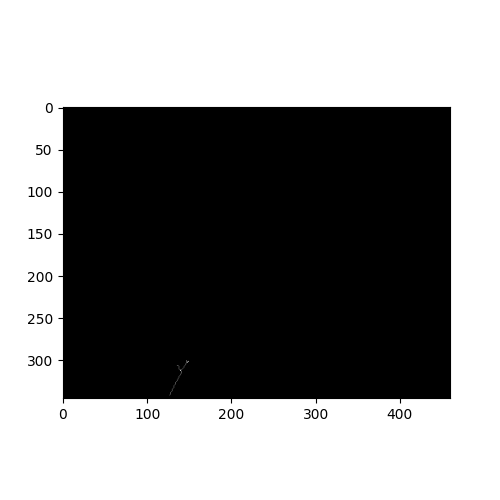

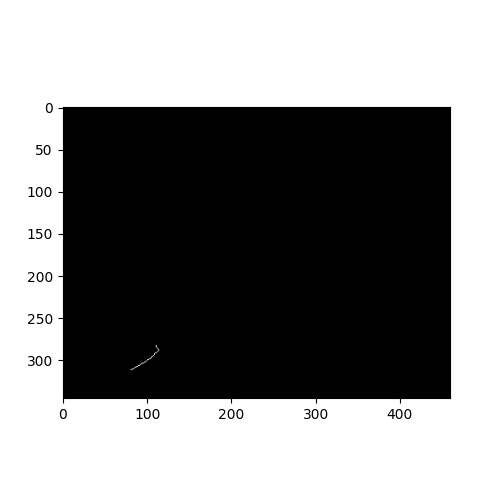

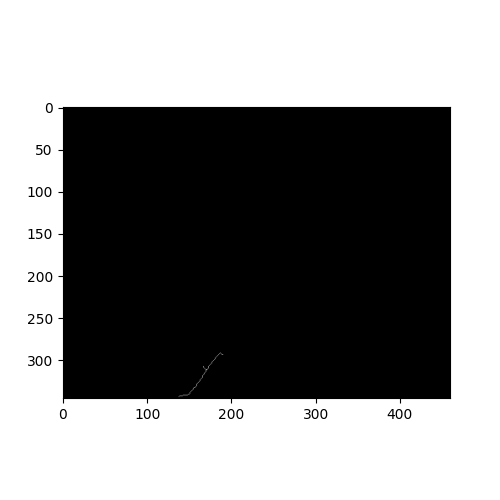

In [5]:
# Instance segmentation with shoot following algorithm


def get_connected_pixels(point, mask):
    """
    Get connected pixels to the point in the mask (8-connectivity).

    Args:
        point (tuple): point coordinates
        mask (np.array): binary mask

    Returns:
        list: list of connected points
    """
    neighbors = [
        (point[0] - 1, point[1] - 1),
        (point[0] - 1, point[1]),
        (point[0] - 1, point[1] + 1),
        (point[0], point[1] - 1),
        (point[0], point[1] + 1),
        (point[0] + 1, point[1] - 1),
        (point[0] + 1, point[1]),
        (point[0] + 1, point[1] + 1),
    ]
    return [
        p
        for p in neighbors
        if 0 <= p[0] < mask.shape[0] and 0 <= p[1] < mask.shape[1] and mask[p] == 1
    ]


def direction(point1, point2):
    """
    Get the direction vector from point1 to point2.

    Args:
        point1 (tuple): point 1
        point2 (tuple): point 2

    Returns:
        tuple: direction vector
    """
    return (point2[0] - point1[0], point2[1] - point1[1])


def follow_shoot(
    mask,
    start_point,
    endpoints,
    used_endpoints,
    branching_points,
    crossing_points,
    visited_points=None,
    parent_direction=None,
):
    if visited_points is None:
        visited_points = set()

    instance = np.zeros_like(mask)  # Blank instance to store the shoot instance
    current_point = start_point  # Start point of the shoot (endpoint)
    direction_vector = parent_direction or (0, 0)  # Shoot direction vector
    branch_points = []  # Store points where branching occurs for recursive following

    while True:  # Follow the shoot until we reach another endpoint
        instance[current_point[0], current_point[1]] = 1  # Add point to the instance
        visited_points.add(tuple(current_point))  # Add point to visited points
        possible_points = get_connected_pixels(current_point, mask)

        # Remove already visited points
        possible_points = [p for p in possible_points if tuple(p) not in visited_points]

        if not possible_points:
            break  # Stop if there are no more connected points (dead end)

        # Handle crossing points (if crossing point, continue straight ahead,
        # only consider the point in the current direction)
        if tuple(current_point) in crossing_points:
            straight_points = sorted(
                possible_points,
                key=lambda p: np.dot(direction_vector, direction(current_point, p)),
                reverse=True,
            )
            if straight_points:
                next_point = straight_points[0]
                direction_vector = direction(current_point, next_point)
                current_point = next_point
            else:
                break

        # Check for branching or overlap
        if len(possible_points) > 1 and tuple(current_point) in branching_points:
            # Sort possible points by direction
            possible_points = sorted(
                possible_points,
                key=lambda p: np.dot(direction_vector, direction(current_point, p)),
                reverse=True,
            )

            # Follow the main branch first
            next_point = possible_points[0]
            new_direction = direction(current_point, next_point)

            # Store the branch points for recursive following later
            for branch_point in possible_points[1:]:
                branch_direction = direction(current_point, branch_point)
                if tuple(branch_point) not in used_endpoints:
                    branch_points.append((branch_point, branch_direction))

            # Update current_point and direction_vector
            direction_vector = new_direction
            current_point = next_point

        else:
            # if neither branching nor crossing, continue in the same direction
            next_point = possible_points[0]
            direction_vector = direction(current_point, next_point)
            current_point = next_point

        # Stop if we reach another endpoint
        if tuple(current_point) in endpoints:
            instance[current_point[0], current_point[1]] = 1
            used_endpoints.add(tuple(current_point))
            break

    # Follow the branches recursively
    for branch_point, branch_direction in branch_points:
        if tuple(branch_point) not in used_endpoints:
            instance += follow_shoot(
                mask,
                branch_point,
                endpoints,
                used_endpoints,
                branching_points,
                crossing_points,
                visited_points,
                branch_direction,
            )

    return instance


instances = []  # Store all the instances
used_endpoints = (
    set()
)  # Set of used endpoints (to avoid following the same shoot multiple times)

# Follow the shoots from each endpoint
for endpoint in endpoints:
    if tuple(endpoint) in used_endpoints:
        continue

    instance = follow_shoot(
        skeletonised_mask,
        tuple(endpoint),
        set(map(tuple, endpoints)),
        used_endpoints,
        branching_points,
        crossing_points,
    )
    instances.append(instance)  # Store the instance
    used_endpoints.add(tuple(endpoint))  # Mark the endpoint as used

print(len(instances))  # Number of instances identified

for i, instance in enumerate(instances):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(instance, cmap="gray")
    plt.show()